In [3]:
!wget https://drive.google.com/file/d/1OJWRb5XakWPL_rZFYDS588ktwXViMYP7

--2019-12-07 15:06:02--  https://drive.google.com/file/d/1OJWRb5XakWPL_rZFYDS588ktwXViMYP7
Resolving drive.google.com (drive.google.com)... 108.177.111.113, 108.177.111.138, 108.177.111.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.111.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/1OJWRb5XakWPL_rZFYDS588ktwXViMYP7/ [following]
--2019-12-07 15:06:02--  https://drive.google.com/file/d/1OJWRb5XakWPL_rZFYDS588ktwXViMYP7/
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/1OJWRb5XakWPL_rZFYDS588ktwXViMYP7/edit [following]
--2019-12-07 15:06:02--  https://drive.google.com/file/d/1OJWRb5XakWPL_rZFYDS588ktwXViMYP7/edit
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘1OJWRb5XakWPL_rZFYDS588ktwXVi

In [73]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [24]:
path_to_data = '../../data/hw2_q2.pkl'

In [37]:
with open(path_to_data, 'rb') as file:
    data = pickle.load(file)

In [56]:
train = data['train']
test = data['test']

In [59]:
train[0].shape

(32, 32, 3)

In [67]:
np.min(train[0])

0

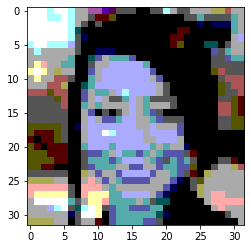

In [70]:
plt.imshow(data['train'][10] * 85)

In [ ]:
def tuple_flip(a_tuple: tuple):
    return (a_tuple[1], a_tuple[0])

class SumBlock(nn.Module):
    def __init__(self, n_in, n_filters):
        super().__init__()
        self.n_in = n_in
        self.n_filters = n_filters
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(n_in, n_filters, (1, 1), (1, 1))

    def forward(self, _h):
        _h = self.relu(_h)
        h = self.conv(_h)
        return h + _h

class ResNetLayer(nn.Module):
    def __init__(self, n_in, n_filters=256, n_blocks=8):
        super().__init__()
        self.n_in = n_in
        self.n_out = self.n_in * 2
        self.n_filters = n_filters
        self.n_blocks = n_blocks
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(self.n_in, self.n_filters, (3, 3), (1, 1)))
        for _ in range(self.n_blocks):
            self.layers.append(nn.Conv2d(self.n_filters, self.n_filters, (1, 1), (1, 1)))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Conv2d(self.n_filters, self.n_filters, (3, 3), (1, 1)))
            self.layers.append(SumBlock(self.n_filters, self.n_filters))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(self.n_filters, self.n_out, (3, 3), (1, 1)))
        
    def forward(self, x):
        z = x
        for layer in self.layers:
            z = layer(z)
        return z      
    
class AffineCoupling(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.n_in = n_in
        self.resnet = ResNetLayer(n_in)

    def forward(self, x):
        x1, x2 = x
        y1 = x1
        y2 = x2
        log_s, t = torch.split(self.resnet(x1), 2, axis=-1)
        y2 = torch.exp(log_s) * (y1 + t)
        return (y1, y2)

In [178]:
kek = ResNetLayer(3, 2)
test_input = torch.from_numpy(train[:10]).view(-1, 3, 32, 32)
test_input = test_input.float()
kek(test_input).shape

torch.Size([10, 6, 12, 12])

In [188]:
AffineCoupling(1)

AffineCoupling(
  (resnet): ResNetLayer(
    (layers): ModuleList(
      (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (4): SumBlock(
        (relu): ReLU()
        (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (5): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (6): ReLU()
      (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (8): SumBlock(
        (relu): ReLU()
        (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (9): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (10): ReLU()
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (12): SumBlock(
        (relu): ReLU()
        (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (13): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (14): R

In [196]:
AffineCoupling(3)((test_input, test_input))[0].shape

torch.Size([10, 3, 32, 32])